In [1]:
import os
import shutil

import pandas as pd
import tensorflow as tf
import torch
import numpy as np
from transformers import BertTokenizer
import matplotlib.pyplot as plt

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("combined_sports.csv")

C:\Users\kevin\AppData\Local\Temp\ipykernel_21484\2444995808.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_sports.csv")


In [3]:
df.head()

,Text,player,event,sport
0,Attempt missed. Mladen Petric (Hamburg) left f...,mladen petric,1,football
1,"Corner, Borussia Dortmund. Conceded by Dennis...",dennis diekmeier,2,football
2,"Corner, Borussia Dortmund. Conceded by Heiko ...",heiko westermann,2,football
3,Foul by Sven Bender (Borussia Dortmund).,sven bender,3,football
4,Gokhan Tore (Hamburg) wins a free kick in the ...,gokhan tore,8,football


In [4]:
df_train = df[["Text", "sport"]]
df_train.isna().sum()

Text     0
sport    0
dtype: int64

In [5]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

# Sample DataFrame
# df = pd.read_csv('your_dataset.csv')

# Step 1: Label encode the output column (sport)
label_encoder = LabelEncoder()
df['sport'] = label_encoder.fit_transform(df['sport'])

# Step 2: Use StratifiedShuffleSplit to split df into train, validation, and test sets while maintaining the same ratio of cricket and football
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# First, create a stratified split into df_train and df_temp (which will be split further into val and test)
for train_idx, temp_idx in split.split(df, df['sport']):
    df_train = df.iloc[train_idx]
    df_temp = df.iloc[temp_idx]

# Now, split df_temp into df_val and df_test, maintaining the same ratio
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_idx, test_idx in split.split(df_temp, df_temp['sport']):
    df_val = df_temp.iloc[val_idx]
    df_test = df_temp.iloc[test_idx]

# Now you have df_train, df_val, and df_test with the same ratio of cricket to football.

In [6]:
model_name = "bert-base-uncased"
max_length = 512

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from datasets import Dataset

df_train["label"] = df_train["sport"]
train_dataset = Dataset.from_pandas(df_train[["Text","label"]])

C:\Users\kevin\AppData\Local\Temp\ipykernel_21484\1242695915.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["label"] = df_train["sport"]


In [9]:
train_dataset = train_dataset.remove_columns('__index_level_0__')

In [10]:
train_dataset = train_dataset.map(lambda e: tokenizer(e["Text"], padding='max_length', truncation=True), batched=True)

Parameter 'function'=<function <lambda> at 0x000002ACFE5F4860> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|████████████████████████████████████████████████████████████████████████████████| 763/763 [01:54<00:00,  6.69ba/s]


In [11]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [23]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_results",                 # Directory where checkpoints will be saved
    num_train_epochs=2,                          # Number of training epochs
    per_device_eval_batch_size=16,               # Batch size for evaluation
    evaluation_strategy='epoch',                 # Evaluate at the end of every epoch
    logging_dir='./bert_logs',                   # Directory for logging
    logging_steps=10,                            # Log every 10 steps
    save_steps=5000,                             # Save checkpoint every 5000 steps
    save_total_limit=2                           # Keep only the last 2 checkpoints (optional)
)

trainer = Trainer(
    model=model,                                 # The model being trained
    args=training_args,                          # Training arguments
    train_dataset=train_dataset,                 # Training dataset
    eval_dataset=train_dataset,                  # Evaluation dataset (for demo, using train_dataset)
    compute_metrics=compute_metrics              # Function to compute metrics during evaluation
)


C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
trainer.train(resume_from_checkpoint="./bert_results/checkpoint-150000")

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\transformers\trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint,

Epoch,Training Loss,Validation Loss,Accuracy
2,0.000000,0.000000,1.000000


TrainOutput(global_step=190518, training_loss=0.0, metrics={'train_runtime': 44529.1317, 'train_samples_per_second': 34.228, 'train_steps_per_second': 4.279, 'total_flos': 4.010159790279475e+17, 'train_loss': 0.0, 'epoch': 2.0})

In [28]:
from datasets import Dataset

df_test["label"] = df_test["sport"]
test_dataset = Dataset.from_pandas(df_test[["Text","label"]])

C:\Users\kevin\AppData\Local\Temp\ipykernel_21484\2666176314.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["label"] = df_test["sport"]


In [29]:
test_dataset = test_dataset.remove_columns('__index_level_0__')

In [31]:
test_dataset = test_dataset.map(lambda e: tokenizer(e["Text"], padding='max_length', truncation=True), batched=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:16<00:00,  5.70ba/s]


In [32]:
pred = trainer.predict(test_dataset)

In [33]:
df_test["pred"] = pred[1]

C:\Users\kevin\AppData\Local\Temp\ipykernel_21484\2430006148.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["pred"] = pred[1]


In [34]:
df_test.head()

,Text,player,event,sport,label,pred
218914,Walter Gargano (Inter Milan) wins a free kick ...,walter gargano,8,1,1,1
881811,Foul by Daniele Baselli (Torino).,daniele baselli,3,1,1,1
544853,Booking Lee Cattermole (Sunderland) is sh...,lee cattermole,4,1,1,1
290774,Jorge Molina (Real Betis) wins a free kick in ...,jorge molina,8,1,1,1
192269,Fernando Llorente (Athletic Bilbao) wins a fre...,fernando llorente,8,1,1,1


In [35]:
y_true_decoded = label_encoder.inverse_transform(df_test['label'])
y_pred_decoded = label_encoder.inverse_transform(df_test['pred'])

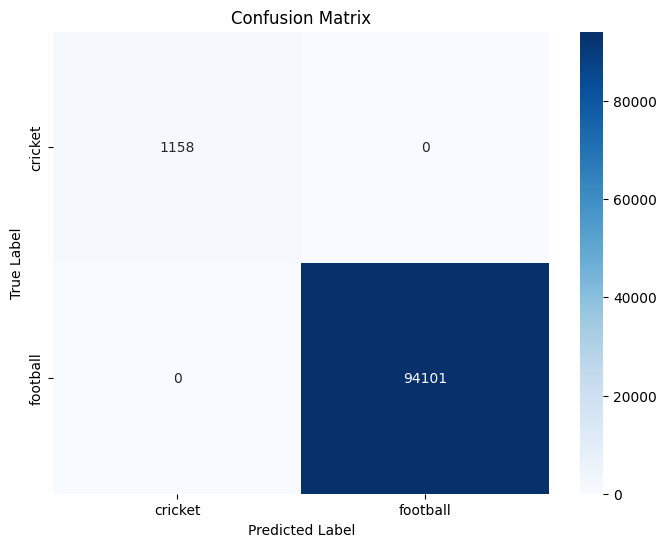

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_true_decoded, y_pred_decoded)

# Plotting Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()